# In this notebook:

1. Visualising entities highlighted in text
2. Visualising a network of entities



In [62]:
import nltk
import numpy
import string
import matplotlib.pyplot as plt

In [2]:
# let's import the needed libraries.  We'll keep working with the inaugural corpus
# first time running, nltk.download('inaugural')
from nltk.corpus import inaugural

# 1. Entities highlighted in text

Let's look at the named entities recognition and highlighting it in text.  To do that we can use a tool that accompanies ``spaCy`` called ```displacy```.

`displacy.render(doc, style="ent",jupyter=True)`  would visualise the text with the entities highlighted.

Here is a list of entity types:

```
NER: 
CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART
```

For more details browse https://spacy.io/api/annotation#named-entities to see the label scheme 
or use ``spacy.explain('GPE')`` to check what each of the tags mean.

In [3]:
import spacy
from spacy import displacy

# we reload the model (just in case)
nlp = spacy.load('en_core_web_sm')

# we define a example bit of text by concatenating a couple of sentences togeter.
text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, "
text += "few people outside of the company took him seriously. Not it changed the Unided States and the world"

# this runs space on the text
doc = nlp(text)

# this displays the text with the entities highlighted in different colours
displacy.render(doc, style="ent",jupyter=True)


### 🐛Let's test a short code 1.1

Do this highlighting for Obama's speech. Tip: to get the Obama speech from NLTK you can call `inaugural.raw('2009-Obama.txt')`.  You need the raw text as input into spaCy.

In [63]:
text=inaugural.raw('2009-Obama.txt')
doc = nlp(text)
displacy.render(doc, style="ent",jupyter=True)


In [4]:
from nltk.corpus import PlaintextCorpusReader
corpus_root = "barack_obama_speeches"
corpus_data = PlaintextCorpusReader(corpus_root, '.*', encoding='latin1') 
plain_text = corpus_data.raw()[:2000] # look at the first 2000 characters only
doc = nlp(plain_text)
displacy.render(doc, style="ent",jupyter=True)

# 2. Visualising a network of entities


We can use network visualisations to show how things are connected in data.  Networks are often used for showing networks of people in social media.  We'll use a network visualisation to display how all US presidents are connected in terms of the people they mention in their speeches.

To do that we'll first learn how to save data to a file. The content of file serves as the input to the network. Let's first create the content (```file_content```) which we will write to a file.  We'll be creating a tsv (tab-separated file), meaning that each line contains different fields separated by a tab.  The first line is the header which lists the names for each column.  The first column are the names of presidents and the second column the people mentioned in their speeches.

The president/person pairs are created by looping through each speech, extracting the name of each president from the filename of the speech, NER-tagging and extracting people names for each speech.  For all people extracted from each speech, we then concatenate the ```file_content``` variable with the president's name (```president```) and each person name (```person```) mentioned in his speech followed by a newline character ("\n") so that each pair is on one line. The final ```file_content``` contains the header and numerous lines listing all the president/person pairs in this data set.

The following code was adapted from Jonathan Soma's tutorial on [NetworkX Graphs](http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/). __Note: this first bit of code takes some time to run because each speech has to be tagged individually.__

In [5]:
header="president\tperson\n"
file_content=header
for fileid in inaugural.fileids():
    president=fileid[5:-4]
    #nertagged_words = st.tag(inaugural.words(fileid))
    doc = nlp(inaugural.raw(fileid))
    named_entities = [(ent.text, ent.label_) for ent in doc.ents] 
    #named_entities=get_entities(nertagged_words)
    people = [string for (string, tag) in named_entities if (tag == 'PERSON') and (not string.startswith('\n'))]
    if len(people) > 0:
        for person in people:
            file_content=file_content + president + "\t" + person + "\n"

In [6]:
f = open("presidents.tsv", "w")
f.write(file_content)
f.close()

You can check that file was created by looking at the Jupyter Notebook homepage in the browser.  The file should now be listed in the same directory as you notebook.



In [7]:
import pandas as pd
import networkx as nx

First we create a data frame by reading in the csv file which we just created.  The top of the data frame can be displayed by calling the ```head()``` method.

In [17]:
import pandas as pd

# Try reading the file with different encodings
try:
    df = pd.read_csv("presidents.tsv", sep='\t', encoding='utf-8')
except UnicodeDecodeError:
    try:
        
        df = pd.read_csv("presidents.tsv", sep='\t', encoding='latin1')
        print("latin1 works")
    except UnicodeDecodeError:
        df = pd.read_csv("presidents.tsv", sep='\t', encoding='utf-16')
        print("utf-16 works")

# Display the first few rows of the DataFrame
df.head()


latin1 works


,president,person
0,Adams,Providence
1,Jefferson,Fellow Citizens
2,Jefferson,Providence
3,Monroe,Administrations
4,Monroe,North


The first column in the data frame will serve as the source and the second column as the target in the network.  We can create a simple network specifying source and target using the headers of the columns in the data frame.

__Node:__ A network node is a connection point.

__Edge:__ A network edge is a connection between two nodes. 

This initial network isn't very informative yet as you can't see who each node (blue circles) refers to.  So next we need to make it more pretty.

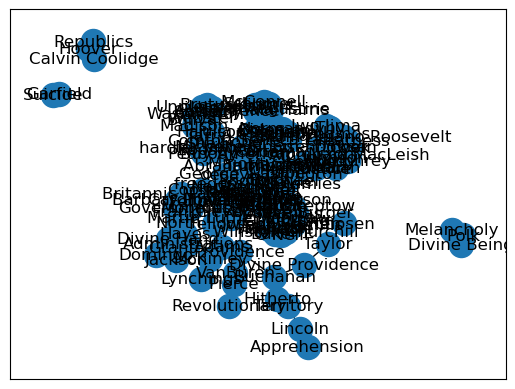

In [27]:
g = nx.from_pandas_edgelist(df, source='president', target='person')

# Draw the graph using Matplotlib
import matplotlib.pyplot as pl
nx.draw_networkx(g, with_labels=True)
pl.show()  # Display the graph

First we need to create a list of all presidents by extracting their names from the data frame and removing repetitions. Note, these are only presidents whose speeches contain person names tagged by the named entity recognition (NER) tagger.

In [28]:
presidents = list(df.president.unique())
presidents

['Adams',
 'Jefferson',
 'Monroe',
 'Jackson',
 'VanBuren',
 'Harrison',
 'Polk',
 'Taylor',
 'Pierce',
 'Buchanan',
 'Lincoln',
 'Grant',
 'Hayes',
 'Garfield',
 'Cleveland',
 'McKinley',
 'Roosevelt',
 'Taft',
 'Coolidge',
 'Hoover',
 'Truman',
 'Eisenhower',
 'Kennedy',
 'Nixon',
 'Carter',
 'Reagan',
 'Bush',
 'Clinton',
 'Obama',
 'Trump',
 'Biden']

We'll do the same for the names of people recognised in the speeches.

In [29]:
people = list(df.person.unique())
people

['Providence',
 'Fellow Citizens',
 'Administrations',
 'North',
 "Britannic Majesty's",
 'Barbary Powers',
 'Governments',
 'Fellow',
 'Jefferson',
 'Madison',
 'Unpleasant',
 'Bolivar',
 'Savior',
 'Anthony',
 'Brutus',
 'Melancholy',
 'Divine Being',
 'Chosen',
 'Divine Providence',
 'Revolutionary',
 'Territory',
 'Hitherto',
 'Apprehension',
 'Domingo',
 'Grant',
 'Divine Hand',
 'Suicide',
 'Washington',
 'Webster',
 'juggler',
 'Lynchings',
 'hardier virtues',
 'Abraham Lincoln',
 'Monroe',
 'Root',
 'Northerners',
 'decay',
 'Calvin Coolidge',
 'Republics',
 'Shall',
 'Comfort',
 'Tarry',
 'Peabody',
 'Chief Justice',
 'Thy',
 'Iwo Jima',
 'Speaker',
 'dynamos',
 'Johnson',
 'Eisenhower',
 'Nixon',
 'Truman',
 'Isaiah',
 'Dirksen',
 'Humphrey',
 'Franklin Delano Roosevelt',
 'Greatness',
 'Archibald MacLeish',
 'Cook',
 'Julia Coleman',
 'Hatfield',
 'Bush',
 'Mondale',
 'Baker',
 "O'Neill",
 'Moomaw',
 'Winston Churchill',
 'Joseph Warren',
 'God',
 'George Washington',
 'Thom

The degree of a node in a network is the number of connections it has to other nodes.  For example, the degree for "Reagan" can be calculated using the ```degree()``` method on initial network.  We will use degree as a way of varying the node size of person nodes, people with a larger degree will be displayed bigger in the network.

In [30]:
g.degree("Reagan")

22

The following bit of code draws the network. The first two lines set the size of the graph and the layout of the network.  

After that the different nodes are drawn using differnt parameters for node_color and node_size.  Then the edges and node labels are drawn and the title of the network is specified.

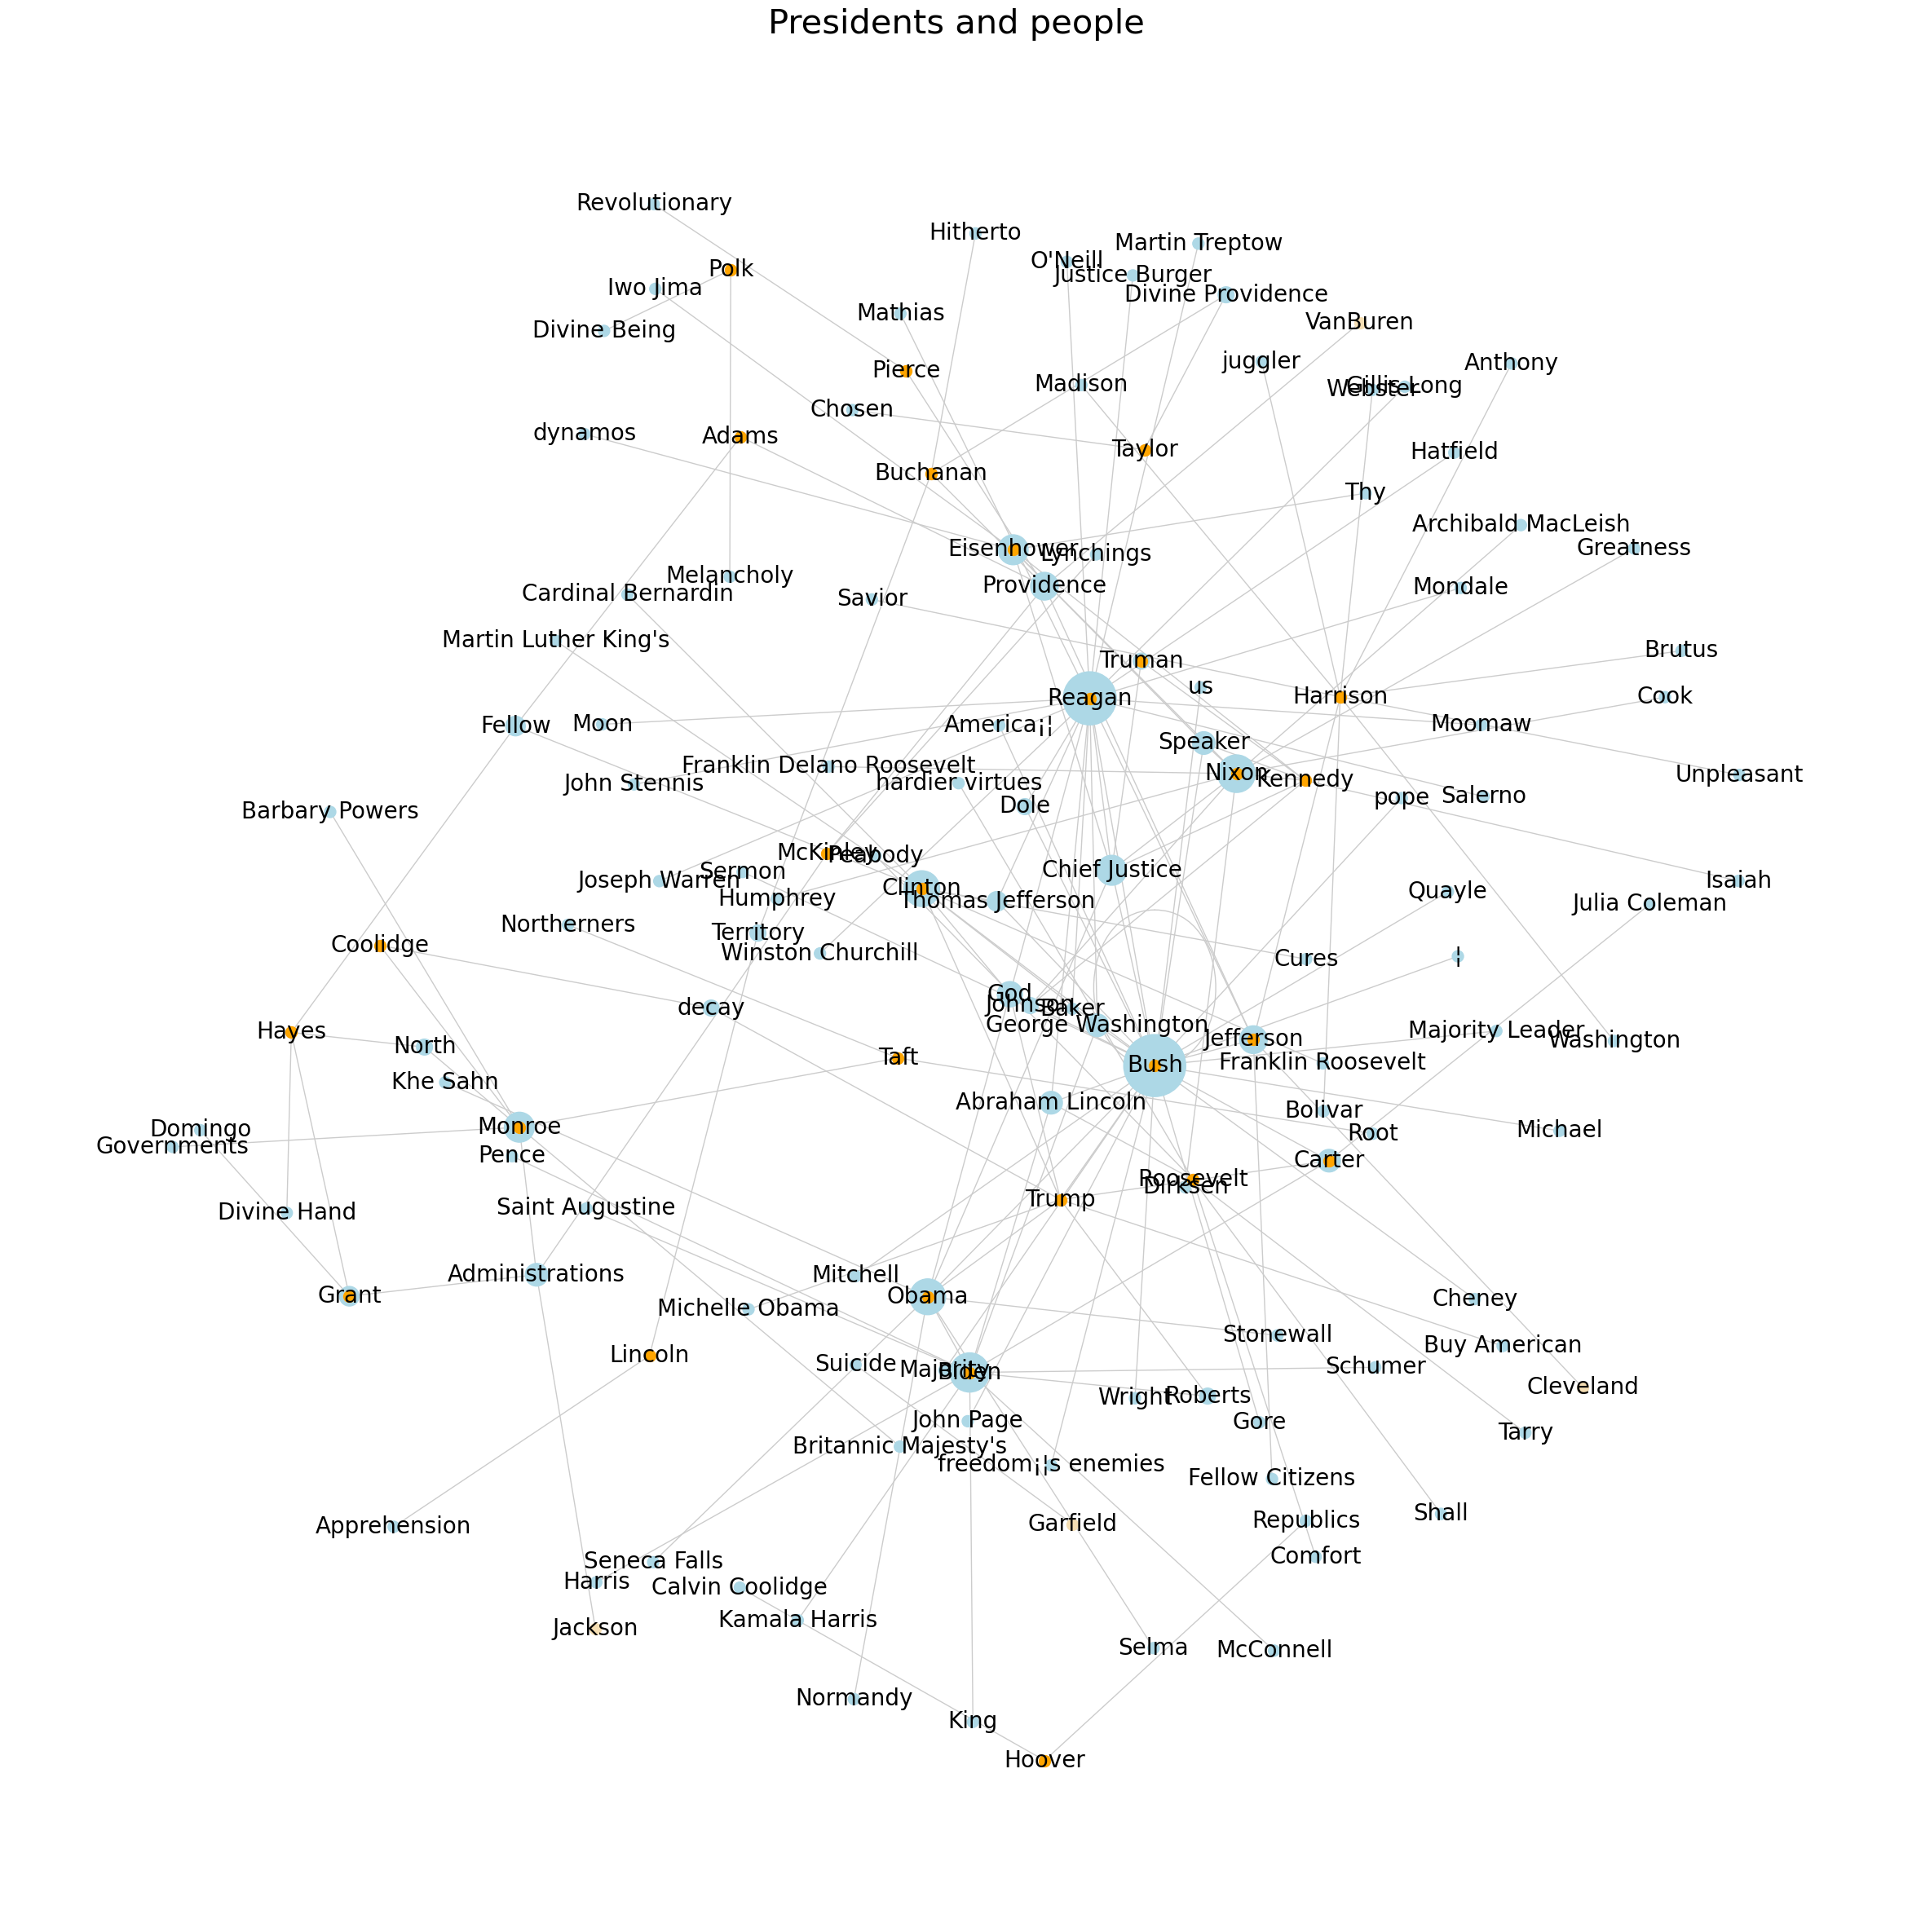

In [31]:
# setting the size of the network
plt.figure(figsize=(30, 30))

# you can choose different ways of laying out the network
layout = nx.spring_layout(g, k = 0.4)

# go through every person name, ask the graph how many
# connections it has. Multiply that by 100 to get the circle size
person_size = [g.degree(person) * 100 for person in people]

# draw the people nodes
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=people,
                       node_color='lightblue',
                       node_size=person_size # a list of sizes, based on g.degree
                       )

# draw president nodes
nx.draw_networkx_nodes(g, layout, nodelist=presidents, node_color='wheat', node_size=100)

# popular presidents (with a degree that's greater than 1)
popular_president = [president for president in presidents if g.degree(president) > 1 ]

# draw popular president nodes
nx.draw_networkx_nodes(g, layout, nodelist=popular_president, node_color='orange', node_size=100)

# draw network edges
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

# draw node labels
nx.draw_networkx_labels(g, layout, font_size=20)

plt.axis('off')
plt.title("Presidents and people", fontsize=30)
plt.show()

When looking at this network, just as a reminder, orange nodes are popular presidents, wheat nodes are other presidents and blue nodes are people mentioned in the speeches.  In some cases presents and people nodes overlap.  In some cases the same person is represented by different nodes (e.g. Roosevelt, Franklin Roosevelt and Franklin Delano Roosevelt).  So this network could be improved if we were able to link some entity mentions to the same person in real life.

### 🐛Let us Try to Visualize the Network of Presidents and Geopolitical Entities



In [56]:
header="president\tentity\n"
file_content=header
for fileid in inaugural.fileids():
    president= fileid[5:-4]
    #nertagged_words = st.tag(inaugural.words(fileid))
    doc = nlp(inaugural.raw(fileid))
    named_entities = [(ent.text, ent.label_) for ent in doc.ents] 
    #named_entities=get_entities(nertagged_words)
    entities = [string for (string, tag) in named_entities if (tag == 'GPE') and (not string.startswith('\n'))]
    if len(entities) > 0:
        for entity in entities:
            file_content=file_content + president + "\t" + entity + "\n"

In [57]:
import io

# Create a DataFrame from the file content
dff = pd.read_csv(io.StringIO(file_content), sep='\t')

# Display the DataFrame
dff


,president,entity
0,Washington,the United States a Government
1,Washington,the United States
2,Washington,America
3,Adams,America
4,Adams,States
...,...,...
668,Biden,America
669,Biden,America
670,Biden,America
671,Biden,America


In [58]:
entities = list(dff.entity.unique())
entities

['the United States a Government',
 'the United States',
 'America',
 'States',
 'republics',
 'Louisiana',
 'Mississippi',
 'Israel',
 'the British Isles',
 'new States',
 'St. Croix',
 'Spain',
 'Amelia Island',
 'Florida',
 'Great Britain',
 'the West Indies',
 'France',
 'Paris',
 'Republics',
 'The United States',
 'New States',
 'Departments',
 'Floridas',
 'Rome',
 'the American States',
 'the District of Columbia',
 'Athens',
 'the United Stages',
 'England',
 'Greece',
 'Camillus',
 'Gaul',
 'Egypt',
 'The Republic of Texas',
 'Texas',
 'New Orleans',
 'Oregon',
 'Missouri',
 'Washington',
 'Republic',
 'North Carolina',
 'Nebraska',
 'Kansas',
 'California',
 'the Atlantic States',
 'Mexico',
 'the Southern States',
 'us',
 'North and South',
 'a united South',
 'Yorktown',
 'United States',
 'North and South America',
 'Monroe',
 'New York',
 'Virginia',
 'Baltimore',
 'Cincinnati',
 'the young Republic',
 'Pennsylvania',
 'American States',
 'Montana',
 'Washington Territor

In [64]:
g = nx.from_pandas_edgelist(dff, source='president', target='entity')

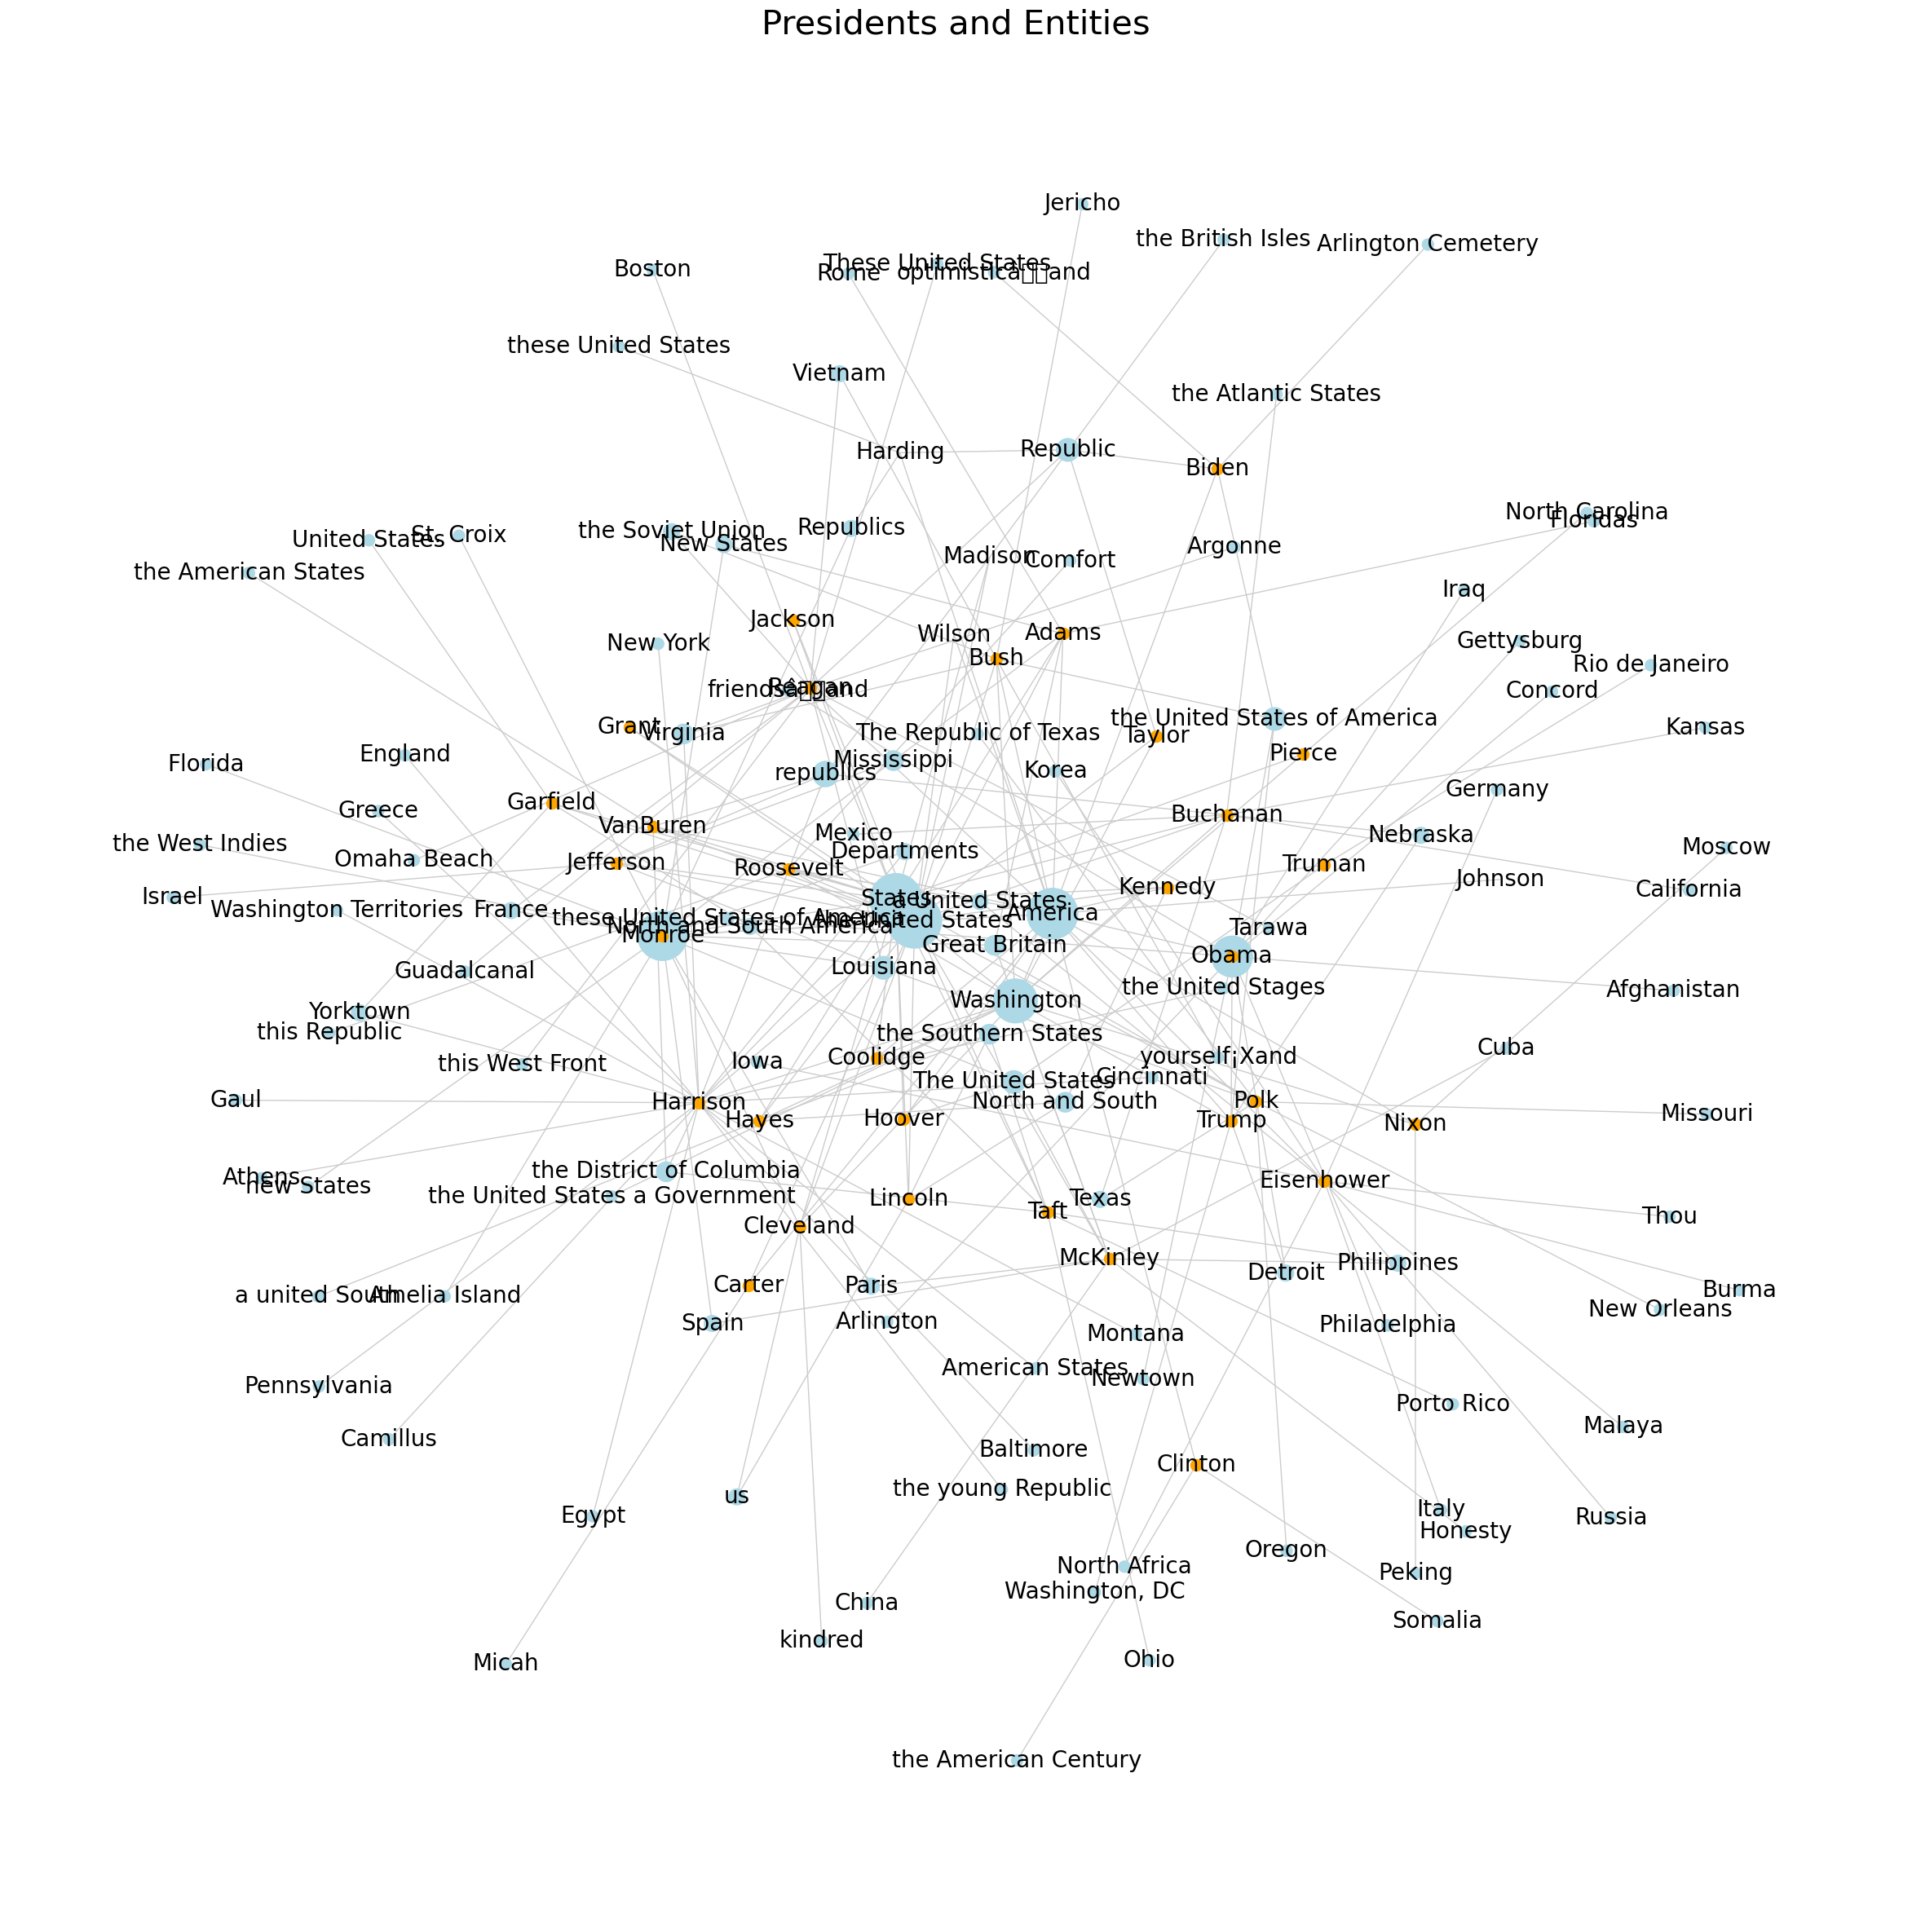

In [61]:
# setting the size of the network
plt.figure(figsize=(30, 30))

# you can choose different ways of laying out the network
layout = nx.spring_layout(g, k = 0.4)

# go through every person name, ask the graph how many
# connections it has. Multiply that by 100 to get the circle size
entity_size = [g.degree(entity) * 100 for entity in entities]

# draw the people nodes
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=entities,
                       node_color='lightblue',
                       node_size=entity_size # a list of sizes, based on g.degree
                       )

# draw president nodes
nx.draw_networkx_nodes(g, layout, nodelist=presidents, node_color='wheat', node_size=100)

# popular presidents (with a degree that's greater than 1)
popular_president = [president for president in presidents if g.degree(president) > 1 ]

# draw popular president nodes
nx.draw_networkx_nodes(g, layout, nodelist=popular_president, node_color='orange', node_size=100)

# draw network edges
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

# draw node labels
nx.draw_networkx_labels(g, layout, font_size=20)

plt.axis('off')
plt.title("Presidents and Entities", fontsize=30)
plt.show()